### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas as pd
import os

symbols = "NIMB"
csv_path = f"stock_history/{symbols}.csv"
df = pd.read_csv(csv_path)

# Convert 'Date' column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date in ascending order
df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Open,High,Low,Close,% change,Volume,TurnOver
0,2023-02-23,232.2,232.2,213.2,216.0,-8.8,276758.0,60028868.9
1,2023-02-23,232.2,232.2,213.2,216.0,-8.8,276758.0,60028868.9
2,2023-02-23,232.2,232.2,213.2,216.0,-8.8,276758.0,60028868.9
3,2023-02-23,232.2,232.2,213.2,216.0,-8.8,276758.0,60028868.9
4,2023-02-23,232.2,232.2,213.2,216.0,-8.8,276758.0,60028868.9


In [2]:
df.tail()

,Date,Open,High,Low,Close,% change,Volume,TurnOver
2536,2025-04-03,212.0,233.0,210.1,215.61,1.52,176888.0,38427115.7
2537,2025-04-07,217.0,217.0,213.0,213.17,-1.13,70903.0,15215780.5
2538,2025-04-08,211.4,229.0,208.2,213.67,0.23,111787.0,23564279.1
2539,2025-04-09,217.8,218.0,212.0,213.44,-0.11,45896.0,9829574.0
2540,2025-04-10,215.0,216.6,212.8,214.03,0.28,62641.0,13410780.4


In [3]:
df1=df.reset_index()['Close']

In [4]:
df1

0       216.00
1       216.00
2       216.00
3       216.00
4       216.00
         ...  
2536    215.61
2537    213.17
2538    213.67
2539    213.44
2540    214.03
Name: Close, Length: 2541, dtype: float64

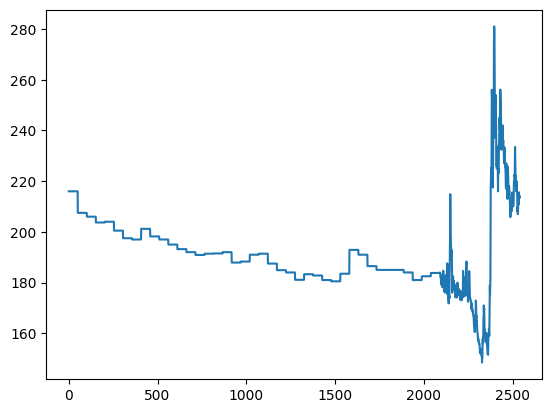

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
import numpy as np

In [7]:
df1

0       216.00
1       216.00
2       216.00
3       216.00
4       216.00
         ...  
2536    215.61
2537    213.17
2538    213.67
2539    213.44
2540    214.03
Name: Close, Length: 2541, dtype: float64

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))



In [9]:
print(df1)

[[0.50943396]
 [0.50943396]
 [0.50943396]
 ...
 [0.49184906]
 [0.49011321]
 [0.49456604]]


In [10]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(1651, 890)

In [12]:
train_data

array([[0.50943396],
       [0.50943396],
       [0.50943396],
       ...,
       [0.32075472],
       [0.32075472],
       [0.32075472]])

In [13]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(1550, 100)
(1550,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(789, 100)
(789,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
from tensorflow.keras.layers import Dropout

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model.compile(loss='mean_squared_error', optimizer='adam')

# Save the trained model (after training)
model.save("StockSanket.h5")



# Print the model summary (optional)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

c:\Users\Bishal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test, ytest), 
          epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
49/49 [==============================] - 14s 171ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 2/100
49/49 [==============================] - 9s 180ms/step - loss: 0.0013 - val_loss: 0.0066
Epoch 3/100
49/49 [==============================] - 9s 184ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 4/100
49/49 [==============================] - 8s 174ms/step - loss: 9.6646e-04 - val_loss: 0.0057
Epoch 5/100
49/49 [==============================] - 9s 180ms/step - loss: 7.5761e-04 - val_loss: 0.0056
Epoch 6/100
49/49 [==============================] - 9s 195ms/step - loss: 8.4776e-04 - val_loss: 0.0056
Epoch 7/100
49/49 [==============================] - 7s 138ms/step - loss: 7.5327e-04 - val_loss: 0.0055
Epoch 8/100
49/49 [==============================] - 6s 126ms/step - loss: 8.7673e-04 - val_loss: 0.0058
Epoch 9/100
49/49 [==============================] - 6s 118ms/step - loss: 7.7306e-04 - val_loss: 0.0054
Epoch 10/100
49/49 [==============================] - 7s 134ms/ste

In [21]:
import tensorflow as tf

In [22]:
tf.__version__

'2.13.0'

In [23]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

25/25 [==============================] - 1s 38ms/step


In [24]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
# Calculate RMSE for training and testing
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(ytest, test_predict))


In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train, train_predict)
test_mape = mean_absolute_percentage_error(ytest, test_predict)

train_accuracy = 100 - train_mape
test_accuracy = 100 - test_mape


C:\Users\Bishal\AppData\Local\Temp\ipykernel_3716\117373069.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


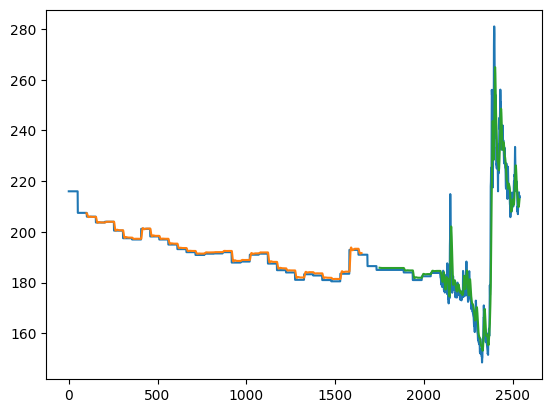

In [27]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [28]:
len(test_data)

890

In [29]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 549)

In [30]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [31]:
temp_input

[0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735849056,
 0.2566037735

In [32]:
# 📌 Cell 1: Generate 7-day Close predictions
from numpy import array

lst_output = []
n_steps = 100
i = 0

while i < 7:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Inverse scale the predictions
forecast_prices = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten()


In [33]:
# 📌 Cell 2: Generate synthetic OHLC for predicted 7 days
from datetime import timedelta
import numpy as np

last_date = pd.to_datetime(df['Date'].iloc[-1])
last_close = df['Close'].iloc[-1]

predicted_7_days = []

for close_price in forecast_prices:
    date = last_date + timedelta(days=1)
    while date.weekday() >= 5:  # skip weekends
        date += timedelta(days=1)

    open_price = last_close * (1 + np.random.uniform(-0.01, 0.01))
    high_price = max(open_price, close_price) * (1 + np.random.uniform(0.001, 0.015))
    low_price = min(open_price, close_price) * (1 - np.random.uniform(0.001, 0.015))

    predicted_7_days.append({
        "date": date.strftime('%Y-%m-%d'),
        "open": round(open_price, 2),
        "high": round(high_price, 2),
        "low": round(low_price, 2),
        "close": round(close_price, 2)
    })

    last_close = close_price
    last_date = date


In [34]:
# 📌 Cell 3: Save full JSON (past + prediction)
import os
import json

output_dir = os.path.join("predictions", symbols)
os.makedirs(output_dir, exist_ok=True)

# Convert 'Date' to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Pull past 30 OHLC days
past_30_df = df[["Date", "Open", "High", "Low", "Close"]].tail(30)
past_30_list = [
    {
        "date": row["Date"].strftime("%Y-%m-%d"),
        "open": round(row["Open"], 2),
        "high": round(row["High"], 2),
        "low": round(row["Low"], 2),
        "close": round(row["Close"], 2)
    }
    for _, row in past_30_df.iterrows()
]

output_data = {
    "past_30_days": past_30_list,
    "predicted_7_days": predicted_7_days,
    "train_rmse": train_rmse if 'train_rmse' in locals() else None,
    "test_rmse": test_rmse if 'test_rmse' in locals() else None,
    "train_accuracy": train_accuracy if 'train_accuracy' in locals() else None,
    "test_accuracy": test_accuracy if 'test_accuracy' in locals() else None
}

with open(os.path.join(output_dir, f"{symbols}.json"), "w") as f:
    json.dump(output_data, f, indent=4)


In [35]:
day_new=np.arange(1,101)
day_pred = np.arange(101, 108)  # For 7 days

In [36]:
import matplotlib.pyplot as plt

In [37]:
len(df1)

2541

In [38]:
import os

output_dir = f"predictions/{symbols}"
os.makedirs(output_dir, exist_ok=True)


In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Optional: Set figure size for better clarity

# Plot past 100 days
plt.plot(day_new, scaler.inverse_transform(np.array(df1[-100:]).reshape(-1, 1)), label="Past 100 Days")

# Plot next 7 predicted days
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), label="Next 7 Days")

plt.title(f"{symbols} — Forecast vs History")
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)

# Ensure output folder exists
os.makedirs(output_dir, exist_ok=True)

# Save plot before plt.show()
chart_path = os.path.join(output_dir, f"{symbols}_chart1.png")
plt.savefig(chart_path, bbox_inches="tight")  # Use bbox_inches to capture full content
plt.close()  # Close to free memory and prevent display issues in batch runs


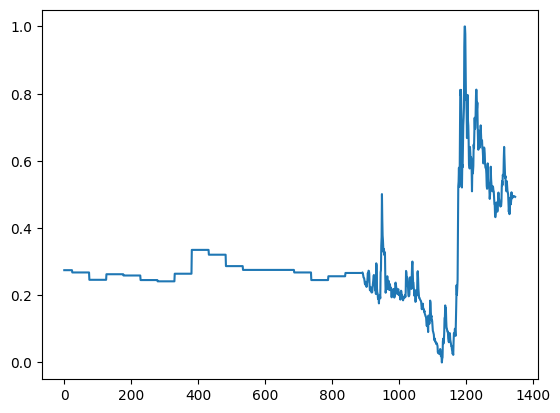

In [40]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [41]:
df3=scaler.inverse_transform(df3).tolist()

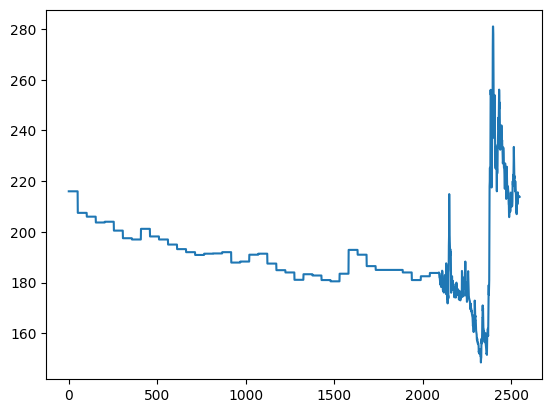

In [42]:
plt.plot(df3)


In [43]:
last_date = pd.to_datetime(df["Date"].iloc[-1])
forecast_dates = [(last_date + pd.Timedelta(days=i)).strftime("%Y-%m-%d") for i in range(1, 8)]


In [44]:

import os
output_dir = 'stock_prediction'
os.makedirs(output_dir, exist_ok=True)
